In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display
import urllib.request
import pandas as pd
import numpy as np
import zipfile
import string
import tools
import time
import os
import re

%matplotlib inline
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

In [2]:
class DownloadProgress:
    def __init__(self):
        self.start_time = time.time()
        self.last_length = 0

    def __call__ (self, block_num, block_size, total_size):
        now = time.time()
        dt = now - self.start_time
        downloaded = block_num * block_size
        p = downloaded/total_size
        eta = dt / p - dt if p > 0 else np.inf
        s = f"[{self.__class__.sizeof_fmt(downloaded)}/{self.__class__.sizeof_fmt(total_size)}] ({(100*p):.2f}%), Elapsed: {self.__class__.time_fmt(dt)}, ETA: {self.__class__.time_fmt(eta)}"
        l = len(s)
        padding = max(0, self.last_length-l)
        self.last_length = l
        print(s, end=" "*padding + ("\r" if downloaded < total_size else "\n"))

    @staticmethod
    def time_fmt(seconds):
        if np.isinf(seconds):
            return "inf"
        elif seconds < 60:
            return f"{seconds:.2f}s"
        elif seconds < 3600:
            return f"{(seconds/60):.2f}min"
        else:
            return f"{(seconds/3600):.2f}hr"

    
    @staticmethod
    def sizeof_fmt(num, suffix="B"):
        for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
            if abs(num) < 1024.0:
                return f"{num:3.1f}{unit}{suffix}"
            num /= 1024.0
        return f"{num:.1f}Yi{suffix}"


In [3]:
def ensure_file_exists(data_dir="data", zip_filename="glove.twitter.27B.zip", txt_filename="glove.twitter.27B.25d.txt", verbose=True):
    zip_path = os.path.join(data_dir, zip_filename)
    txt_path = os.path.join(data_dir, txt_filename)

    if not os.path.exists(txt_path):
        urllib.request.urlretrieve(f"https://nlp.stanford.edu/data/{zip_filename}", zip_path, DownloadProgress() if verbose else None)
        if verbose:
            print("Extracting ZIP file")
        with zipfile.ZipFile(zip_path, "r") as zip_file:
            zip_file.extractall(data_dir)
        assert os.path.exists(txt_path)
        os.unlink(zip_path)
        if verbose:
            print("Done")

if __name__ == "__main__":
    ensure_file_exists()


1.000000,-0.113380,-0.021717,-0.015064,0.057692,0.019767,-0.009591,-0.036780,-0.083254,0.063773,0.033034,-0.045619,-0.014589,0.072419,0.009077,0.026942,-0.021282,0.042563,0.003985,-0.034262,-0.048188,0.036019,-0.080390,-0.033925,-0.024698
-0.113380,1.000000,0.062510,0.022437,0.056172,0.041119,-0.139945,0.087254,0.066505,-0.104079,-0.086796,0.086954,0.026101,-0.068635,-0.073866,0.025790,0.026684,-0.086534,0.020900,0.138643,0.123433,-0.136320,0.127368,0.075693,0.190549
-0.021717,0.062510,1.000000,0.019144,0.004550,0.063141,-0.028727,-0.011098,0.049616,-0.076678,0.000199,0.024252,0.017214,0.018407,-0.081810,-0.045587,0.029120,0.011353,-0.009553,0.010499,0.033970,-0.019680,0.024227,0.042732,-0.005219
-0.015064,0.022437,0.019144,1.000000,0.037096,0.022511,-0.010264,0.011148,0.005065,0.054663,0.059437,-0.041682,0.112364,0.039938,-0.019166,0.072344,-0.013143,0.016816,0.026513,-0.053414,0.131945,0.054073,0.003206,0.126171,0.018134
0.057692,0.056172,0.004550,0.037096,1.000000,0.076061,0.091587,0.003438,-0.000809,-0.067976,0.017552,0.036941,0.118412,0.088378,-0.110837,-0.013412,0.009046,0.023337,-0.006835,-0.047769,0.063666,-0.018416,0.111865,0.008346,-0.047469
0.019767,0.041119,0.063141,0.022511,0.076061,1.000000,-0.063209,-0.039598,0.086646,-0.037600,0.019481,0.110101,0.066671,0.042235,-0.030204,-0.061486,-0.019692,-0.042467,-0.002753,0.027654,0.113479,-0.137123,0.032469,0.112559,0.085665
-0.009591,-0.139945,-0.028727,-0.010264,0.091587,-0.063209,1.000000,-0.035564,-0.112932,0.126118,0.017441,0.169566,0.231281,0.103982,0.047409,0.018320,-0.100713,-0.064748,-0.001249,-0.063317,-0.063435,-0.002191,0.045569,0.038127,-0.026338
-0.036780,0.087254,-0.011098,0.011148,0.003438,-0.039598,-0.035564,1.000000,0.067539,-0.032909,-0.010076,-0.027237,-0.002776,-0.016171,-0.014721,0.070891,-0.011647,-0.011632,0.000485,0.012924,0.014160,0.021815,0.084736,0.035272,-0.008353
-0.083254,0.066505,0.049616,0.005065,-0.000809,0.086646,-0.112932,0.067539,1.000000,-0.019195,0.035412,0.050633,-0.060531,-0.104026,0.034520,-0.075080,0.000980,0.030250,0.014134,0.046309,0.000796,-0.120267,0.036506,0.004064,0.065895
0.063773,-0.104079,-0.076678,0.054663,-0.067976,-0.037600,0.126118,-0.032909,-0.019195,1.000000,0.074980,0.025013,0.117396,0.056246,-0.003940,-0.021104,0.033331,0.000991,-0.041089,-0.139550,-0.016172,0.077272,-0.084401,-0.019333,-0.044066
0.033034,-0.086796,0.000199,0.059437,0.017552,0.019481,0.017441,-0.010076,0.035412,0.074980,1.000000,0.019117,0.027968,-0.016903,0.026007,-0.039419,-0.017899,0.048663,0.034361,-0.088738,-0.088066,-0.025507,-0.029302,-0.058386,-0.001877


1.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
-0.000000,-0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000
-0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000
0.000000,-0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000
0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.000000,0.000001,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000


Reducing word embedding from 25dim to 25dim
100.00% of information retained


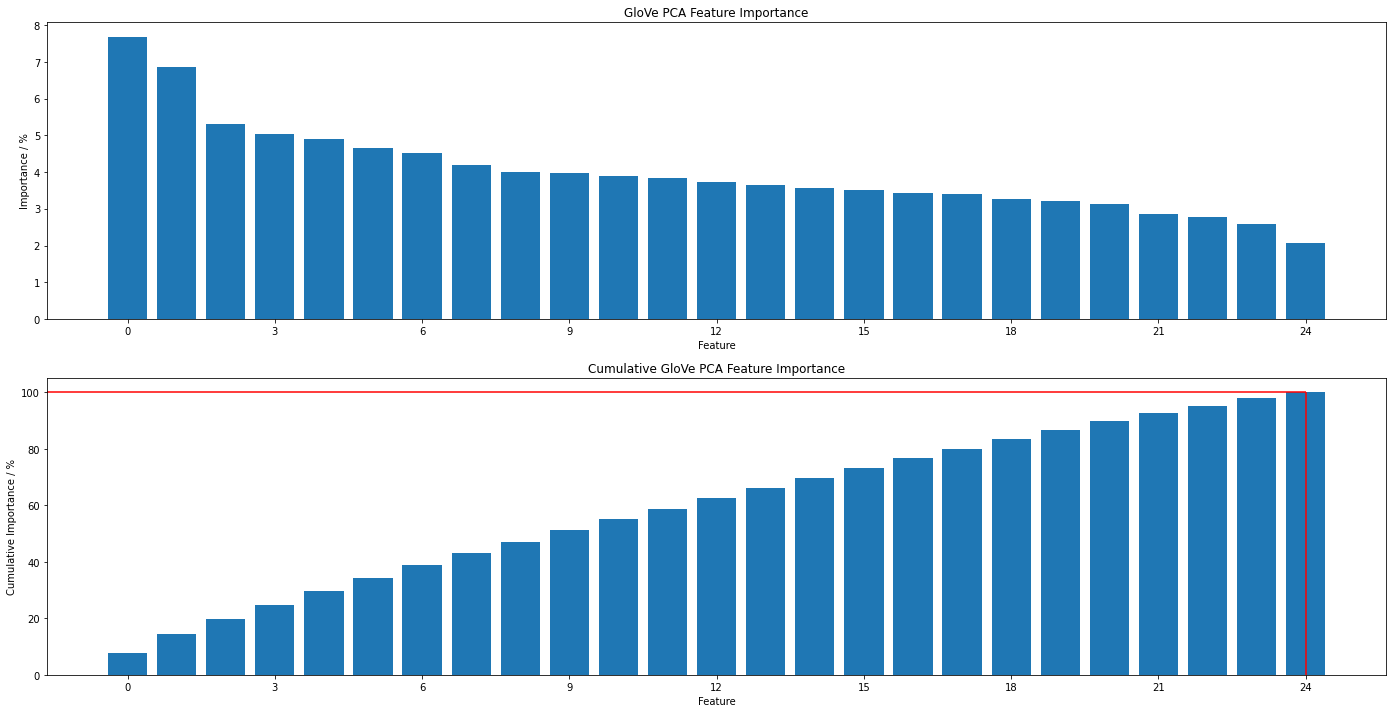

In [4]:
def load_vectors(data_dir="data", zip_filename="glove.twitter.27B.zip", txt_filename="glove.twitter.27B.25d.txt", verbose=False, corr_truncation=30, max_embedding_dim=None, use_pca=False):
    ensure_file_exists(data_dir=data_dir, zip_filename=zip_filename, txt_filename=txt_filename, verbose=verbose)

    vectors = []
    word_indices = {}

    with open(os.path.join(data_dir, txt_filename), "r", encoding="utf-8") as glove_file:
        for i, line in enumerate(glove_file):
            word, *vals = line.split(" ")
            vals = np.array(vals, dtype=np.float32)
            vectors.append(vals)
            word = re.sub(r"[^A-Za-z0-9]", "", word).lower()
            if word == "":
                continue
            word_indices[word] = i

    vectors = np.stack(vectors)

    corr_truncation = min(corr_truncation, vectors.shape[1])

    if verbose:
        corr = pd.DataFrame(vectors[:,:corr_truncation]).corr()
        display(tools.style_corr_matrix(corr.style).set_caption(f"Correlation Matrix of first {corr_truncation} GloVe Features Pre-PCA"))

    embedding_dim = vectors.shape[1] if max_embedding_dim is None else min(max_embedding_dim, vectors.shape[1])
    normalizer = StandardScaler()
    normalized = normalizer.fit_transform(vectors)
    pca = PCA(n_components=vectors.shape[1])
    pca_ftrs = pca.fit_transform(normalized)
    reduced_pca_ftrs = pca_ftrs[:, :embedding_dim]
    reduced_raw_ftrs = vectors[:, :embedding_dim]

    if verbose:
        corr = pd.DataFrame(pca_ftrs[:,:corr_truncation]).corr()
        display(tools.style_corr_matrix(corr.style).set_caption(f"Correlation Matrix of first {corr_truncation} GloVe Features Post-PCA"))

        pct_info_retained = np.sum(pca.explained_variance_ratio_[:embedding_dim])
        print(f"Reducing word embedding from {vectors.shape[1]}dim to {embedding_dim}dim")
        print(f"{(100*pct_info_retained):.2f}% of information retained")

        fig, axs = plt.subplots(2, figsize=(24, 12))
        fig.patch.set_facecolor("white")

        i=0

        axs[i].set_title("GloVe PCA Feature Importance")
        axs[i].set_ylabel("Importance / %")
        axs[i].set_xlabel("Feature")
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i].bar(range(pca.n_components), 100 * pca.explained_variance_ratio_)
        i += 1

        axs[i].set_title("Cumulative GloVe PCA Feature Importance")
        axs[i].set_ylabel("Cumulative Importance / %")
        axs[i].set_xlabel("Feature")
        axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[i].bar(range(pca.n_components), 100 * np.cumsum(pca.explained_variance_ratio_))
        xlim = axs[i].get_xlim()
        ylim = axs[i].get_ylim()
        axs[i].vlines(embedding_dim-1, ymin=ylim[0], ymax=100*pct_info_retained, color="red")
        axs[i].hlines(100*pct_info_retained, xmin=xlim[0], xmax=embedding_dim-1, color="red")
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        i += 1

        display(fig)
        plt.close()

    return reduced_pca_ftrs if use_pca else reduced_raw_ftrs, word_indices

if __name__ == "__main__":
    ftrs, word_indices = load_vectors(verbose=True)


In [5]:
def embed(texts, ftrs, word_indices, words_per_sample=None, return_unknown_words=False, allowed_chars=list(string.ascii_lowercase + string.digits + " ")):
    unknown_words = []
    all_vecs = []

    if len(texts) == 0:
        return np.zeros((0,0 if words_per_sample is None else words_per_sample, ftrs.shape[1]))

    for text in texts:
        text = "".join(i if i in allowed_chars else " " for i in text.lower())
        vecs = []
        for word in text.split(" "):
            if word == "":
                continue
            if word in word_indices:
                vecs.append(ftrs[word_indices[word]])
            elif return_unknown_words and word not in unknown_words:
                unknown_words.append(word)
        
        vecs = np.stack(vecs) if len(vecs) else np.array([])
        all_vecs.append(vecs)
    
    max_text_length = np.max(list(x.shape[0] for x in all_vecs))
    if words_per_sample is None:
        words_per_sample = max_text_length
    
    embeddings = np.zeros((len(texts), words_per_sample, ftrs.shape[1]))
    for i, vecs in enumerate(all_vecs):
        if len(vecs) == 0:
            continue
        embeddings[i,:min(words_per_sample, vecs.shape[0])] = vecs[:min(words_per_sample, vecs.shape[0])]
    
    if return_unknown_words:
        return embeddings, unknown_words
    else:
        return embeddings

if __name__ == "__main__":
    print(embed(["Hello, world!", "Nice to see you :)"], ftrs, word_indices))

[[[-1.2561959  -2.71429467  1.82354045  2.91851187  2.21646905
    0.41064271  0.93314004  2.25964165 -1.84539592  0.16554624
   -1.76441181 -0.05303293 -1.05130899 -0.33083513 -0.73617023
   -0.01115119  0.44643599  0.67424005  0.56075054  0.98291332
    0.15539955  1.63520288  0.38750908  1.64869118  0.96062666]
  [-0.78176945 -0.2652877   0.58080834  2.08097005  0.8382712
   -1.05059171 -0.7355119   0.31076685 -0.11306133  0.84517968
   -2.20371437  1.00286138 -0.83916414 -0.66843289  0.44100451
    1.1837132   0.73150361 -0.15557833  1.02743256  0.63273728
    1.04397583 -0.51630086  0.25077313 -0.52020842  0.31975099]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.